In [1]:
%load_ext autoreload
%autoreload 2


import sys
import os

from sklearn.linear_model import SGDClassifier, LinearRegression, Lasso, Ridge
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import seaborn as sn
import random
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.manifold import TSNE
import tqdm
import copy
from sklearn.svm import LinearSVC 

from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import TruncatedSVD
import torch
from sklearn.linear_model import SGDClassifier
from rlace import solve_adv_game

from sklearn.svm import LinearSVC

import sklearn
from sklearn.linear_model import LogisticRegression
import random
import pickle
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import neural_network
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import warnings
import argparse
from sklearn.neural_network import MLPClassifier
from collections import defaultdict
import scipy
from scipy import stats
from scipy.stats import pearsonr
import pandas as pd
from rlace import init_classifier
from collections import Counter
from sklearn.linear_model import LogisticRegression

unable to import 'smart_open.gcs', disabling that module


## Generate data

In [2]:
random.seed(0)
np.random.seed(0)

d=10
n=8000
do_mix = True

P_y_is_1_given_z_is_1 = 0.8
P_y_is_1_given_z_is_0 = 1 - P_y_is_1_given_z_is_1

std = 1.0
mean_y_0 = 1 + std
mean_y_1 = 1 - std
mean_z_0 = -1 - std
mean_Z_1 = -1 + std

mean_y = {0: mean_y_0, 1: mean_y_1}
mean_z = {0: mean_z_0, 1: mean_Z_1}


zeros = np.zeros(n//2)
ones = np.ones(n//2)

z = np.concatenate([zeros, ones], axis=0)
y = []

for zz in z:
    if zz == 1:
        if np.random.rand() < P_y_is_1_given_z_is_1:
            y.append(1)
        else:
            y.append(0)
    elif zz == 0:
        if np.random.rand() < P_y_is_1_given_z_is_0:
            y.append(1)
        else:
            y.append(0)
            
y = np.array(y)
X = []
for zz,yy in zip(z,y):
    v = np.concatenate([np.random.normal(loc=mean_y[yy], scale=std, size=d//2),
                        np.random.normal(loc=mean_z[zz], scale=std, size=d//2)])
    X.append(v)
X = np.array(X)
if do_mix:
    X = X @ np.random.randn(d,d)

## Statistics

In [3]:
for zz in [0,1]:
    print ("P[y=1|z={}]".format(zz), (y[z==zz]).mean())
    print ("P[y=0|z={}]".format(zz), 1 - (y[z==zz]).mean())
    
print("================")
for yy in [0,1]:
    print ("P[z=1|y={}]".format(yy), (y[z==zz]).mean())
    print ("P[z=0|y={}]".format(yy), 1 - (y[z==zz]).mean())
    
print("===============")
print("P[y=1]={}".format(y.mean()))
print("P[z=1]={}".format(z.mean()))

P[y=1|z=0] 0.202
P[y=0|z=0] 0.798
P[y=1|z=1] 0.81225
P[y=0|z=1] 0.18774999999999997
P[z=1|y=0] 0.81225
P[z=0|y=0] 0.18774999999999997
P[z=1|y=1] 0.81225
P[z=0|y=1] 0.18774999999999997
P[y=1]=0.507125
P[z=1]=0.5


## Classification accuracy

In [4]:
clf_y = init_classifier()
clf_y.fit(X,y)
print("Y prediction accuracy: {}".format(clf_y.score(X,y)))
clf_z = init_classifier()
clf_z.fit(X,z)
print("Z prediction accuracy: {}".format(clf_z.score(X,z)))

Y prediction accuracy: 0.9885
Z prediction accuracy: 0.983625


## PCA

/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


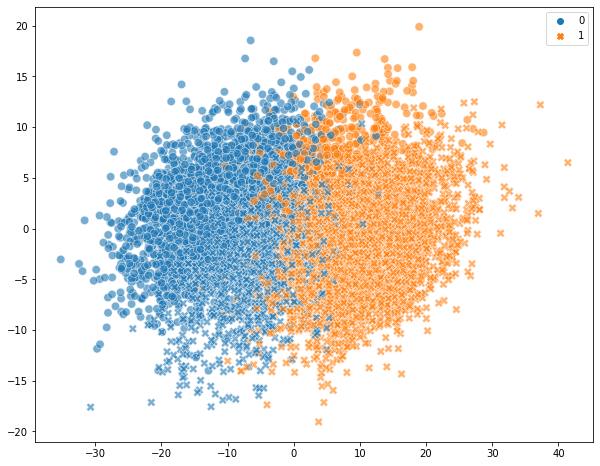

In [5]:
plt.rcParams['figure.figsize'] = [10, 8]
X_pca = PCA(n_components=2).fit_transform(X)
sn.scatterplot(X_pca[:,0], X_pca[:,1], hue = y, style = z, alpha=0.6, s=70)

## Run adversarial game

In [6]:
num_iters = 60000
rank=1
optimizer_class = torch.optim.SGD
optimizer_params_P = {"lr": 0.001, "weight_decay": 1e-4, "momentum":0.5}
optimizer_params_predictor = {"lr": 0.001,"weight_decay": 1e-4, "momentum": 0.5}
epsilon = 0.005 # stop 0.5% from majority acc
batch_size = 256  

output = solve_adv_game(X, z, X, z, rank=rank, device="cuda:0", out_iters=num_iters, optimizer_class=optimizer_class, optimizer_params_P =optimizer_params_P, optimizer_params_predictor=optimizer_params_predictor, epsilon=epsilon,batch_size=batch_size)

21000/60000. Acc post-projection: 50.425%; best so-far: 50.425%; Maj: 50.000%; Gap: 0.425%; best loss so far: 0.699:  35%|###5      | 21000/60000 [1:06:36<2:03:42,  5.25it/s]  


In [7]:
def get_y_hat(trained_clf, X, z):

    preds = trained_clf.predict(X)
    preds_z_0 = trained_clf.predict(X[z==0])
    preds_z_1 = trained_clf.predict(X[z==1])
    couner_preds, counter_preds_z_0, counter_preds_z_1 = Counter(preds), Counter(preds_z_0),  Counter(preds_z_1)
    probs_all = {k:v/sum(couner_preds.values()) for k,v in couner_preds.items()}
    probs_z_0 = {k:v/sum(counter_preds_z_0.values()) for k,v in counter_preds_z_0.items()}
    preds_z_1 = {k:v/sum(counter_preds_z_1.values()) for k,v in counter_preds_z_1.items()}

    return {"preds_all": probs_all, "preds_z_0": probs_z_0, "preds_z_1": preds_z_1}

    
class MyGenderClassifier(object):
    
    def __init__(self, trained_main_task_clf, X, z):
        self.clf = trained_main_task_clf
        
        # collect predictions, find argmax_y | P[Y_hat = y|z=0] - P[Y_hat = y|z=1] | 
        
        preds = get_y_hat(trained_main_task_clf, X, z)
        diffs = {}
        
        for yval in set(preds["preds_all"]):
            diffs[yval] = np.abs(preds["preds_z_0"][yval] - preds["preds_z_1"][yval])
            
        argmax_y = sorted([(yval, diff) for (yval, diff) in diffs.items()], key = lambda pair: pair[1])[-1][0]
        self.argmax_y = argmax_y
        
        # compare P[Y=argmax_y|Z=1], P[Y=argmax_y|Z=0]
        
        self.P_y_is_argmax_y_given_z_is_1 = preds["preds_z_1"][argmax_y]
        self.P_y_is_argmax_y_given_z_is_0 = preds["preds_z_0"][argmax_y]
        self.return_1_on_argmax_y = True if self.P_y_is_argmax_y_given_z_is_1 > self.P_y_is_argmax_y_given_z_is_0 else False
        
    def predict(self, x):
        
        y_hat = self.clf.predict([x])[0]
        
        if self.P_y_is_argmax_y_given_z_is_1 > self.P_y_is_argmax_y_given_z_is_0:
            
            if y_hat == self.argmax_y:               
                return 1
            else:
                return 0           
        else:           
            if y_hat == self.argmax_y:
                return 0
            else:
                return 1

## Collect the distriution of prediction $\hat{Y}$ before and after projection

In [8]:
clf_before = init_classifier()
clf_before.fit(X,y)
preds_before = get_y_hat(clf_before, X, z)
print(clf_before.score(X,y))

0.9885


### P[$\hat{Y}|X$]

In [9]:
preds_before

{'preds_all': {0: 0.489625, 1: 0.510375},
 'preds_z_0': {0: 0.794, 1: 0.206},
 'preds_z_1': {1: 0.81475, 0: 0.18525}}

### P[$\hat{Y}|XP$]

In [10]:
clf_after = init_classifier()
clf_after.fit(X@output["P"],y)
preds_after = get_y_hat(clf_after, X@output["P"], z)
print(clf_after.score(X@output["P"], y))

0.80875


In [11]:
preds_after

{'preds_all': {1: 0.508125, 0: 0.491875},
 'preds_z_0': {1: 0.394, 0: 0.606},
 'preds_z_1': {1: 0.62225, 0: 0.37775}}

### Construct the reduction classifier and calculate its gender prediction accuracy

In [14]:
reduction_clf = MyGenderClassifier(clf_after, X@output["P"],z)

In [16]:
preds_reduction = np.array([reduction_clf.predict(x) for x in X@output["P"]])
reduction_acc = (preds_reduction==z).mean()
print(reduction_acc)

0.614125


### Calcualte accuracy of sklearn classifiers on the projected data $XP$

In [17]:
clf = init_classifier()
clf.fit(X@output["P"],z)
clf.score(X@output["P"],z)

0.499625

In [18]:
clf = init_classifier()
clf.fit(X[y==0]@output["P"],z[y==0])
clf.score(X[y==0]@output["P"],z[y==0])

0.9094598021810804

In [19]:
clf = init_classifier()
clf.fit(X[y==1]@output["P"],z[y==1])
clf.score(X[y==1]@output["P"],z[y==1])

0.9124969189055953